# Exploring Dandiset 001359: Human Patch-seq Electrophysiology for Neuronal Classification

> **Note:** This notebook was generated with the assistance of AI. Users should exercise caution when interpreting the code or results and verify important findings independently.

## Overview

This notebook introduces and explores **Dandiset 001359** (["20250331_AIBS_Patchseq_human"](https://dandiarchive.org/dandiset/001359/0.250401.1603)), a dataset providing intracellular electrophysiology recordings from human neurons using the Patch-seq technique. The dataset was generated by researchers at the Allen Institute for Brain Science and collaborators.

Patch-seq combines electrophysiological recordings with transcriptomics at the single-cell level, enabling multimodal classification of neuron types in the human brain. The dataset contains standardized voltage and current clamp recordings from 33 human subjects across 391 NWB files.

### This Notebook Covers:

1. Exploring the structure and organization of the Dandiset
2. Examining the content and metadata of a representative NWB file
3. Loading and visualizing electrophysiology data (voltage and current recordings)
4. Exploring spike detection data and visualizing spike times
5. Understanding the experimental protocol through epochs (intervals) annotation

By the end of this notebook, you should be comfortable accessing and analyzing the electrophysiology data in this Dandiset for your own research purposes.

## Required Packages

In [1]:
import pynwb
import h5py
import remfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dandi.dandiapi import DandiAPIClient
from collections import Counter

## Dandiset Metadata

In [2]:
# Connect to the DANDI API and get dandiset information
client = DandiAPIClient()
dandiset = client.get_dandiset("001359", "0.250401.1603")
metadata = dandiset.get_raw_metadata()

# Display basic info about the dandiset
print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")
print(f"Dandiset description: {metadata.get('description', 'No description available')[:300]}...")
print(f"License: {metadata.get('license')}")
print(f"Contact: {metadata.get('contributor', [{}])[0].get('name', 'Unknown')}")

Dandiset name: 20250331_AIBS_Patchseq_human
Dandiset URL: https://dandiarchive.org/dandiset/001359/0.250401.1603
Dandiset description: HMBA Lein PatchSeq upload (human) (Q1 2025)...
License: ['spdx:CC-BY-4.0']
Contact: Gonzalez, Limary


## Exploring the Dataset Structure

In [3]:
# Get all .nwb assets
assets = list(dandiset.get_assets_by_glob("*.nwb"))

# Summarize structure
paths = [asset.path for asset in assets]

# Count number of unique top-level subject/session folders
subjects = set()
for p in paths:
    parts = p.split("/")
    if len(parts) > 0 and parts[0].startswith('sub-'):
        subjects.add(parts[0])

num_files = len(paths)
num_subjects = len(subjects)

# Show first 10 files as sample
sample_files = paths[:10]

print(f"Total NWB files: {num_files}")
print(f"Unique subjects (sub-XXX): {num_subjects}")
print("\nSample NWB file paths:")
for p in sample_files:
    print(f"- {p}")

Total NWB files: 391
Unique subjects (sub-XXX): 33

Sample NWB file paths:
- sub-1203384279/sub-1203384279_ses-1207984257_icephys.nwb
- sub-1203384279/sub-1203384279_ses-1207304122_icephys.nwb
- sub-1203384279/sub-1203384279_ses-1207262032_icephys.nwb
- sub-1203384279/sub-1203384279_ses-1207418023_icephys.nwb
- sub-1203384279/sub-1203384279_ses-1208065964_icephys.nwb
- sub-1213383385/sub-1213383385_ses-1213430531_icephys.nwb
- sub-1211237280/sub-1211237280_ses-1211340847_icephys.nwb
- sub-1213383385/sub-1213383385_ses-1213420947_icephys.nwb
- sub-1213383385/sub-1213383385_ses-1213591749_icephys.nwb
- sub-1213383385/sub-1213383385_ses-1213661643_icephys.nwb


## Loading a Representative NWB File

Let's examine the structure of an example NWB file from this Dandiset. We'll select a representative file and access it remotely rather than downloading it first.

In [4]:
# Select a specific NWB file to explore
nwb_path = "sub-1203384279/sub-1203384279_ses-1207984257_icephys.nwb"

# Access the file remotely
asset = next(dandiset.get_assets_by_glob(nwb_path))
remote_file = remfile.File(asset.download_url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

# Display session and subject metadata
print(f"Session ID: {nwb.session_id}")
print(f"Session start time: {nwb.session_start_time}")
print(f"Institution: {nwb.institution}")
print("\nSubject information:")
print(f"  Subject ID: {nwb.subject.subject_id}")
print(f"  Species: {nwb.subject.species}")
print(f"  Sex: {nwb.subject.sex}")
print(f"  Age: {nwb.subject.age}")

/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.4 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Session ID: 1207984257
Session start time: 2022-09-07 17:13:04.880000+00:00
Institution: Allen Institute for Brain Science

Subject information:
  Subject ID: 1203384279
  Species: Homo sapiens
  Sex: M
  Age: P21170.0D


## File Contents and Structure

Let's examine what types of data are contained in this NWB file, including acquisition sweeps, spike detection, and other key structures.

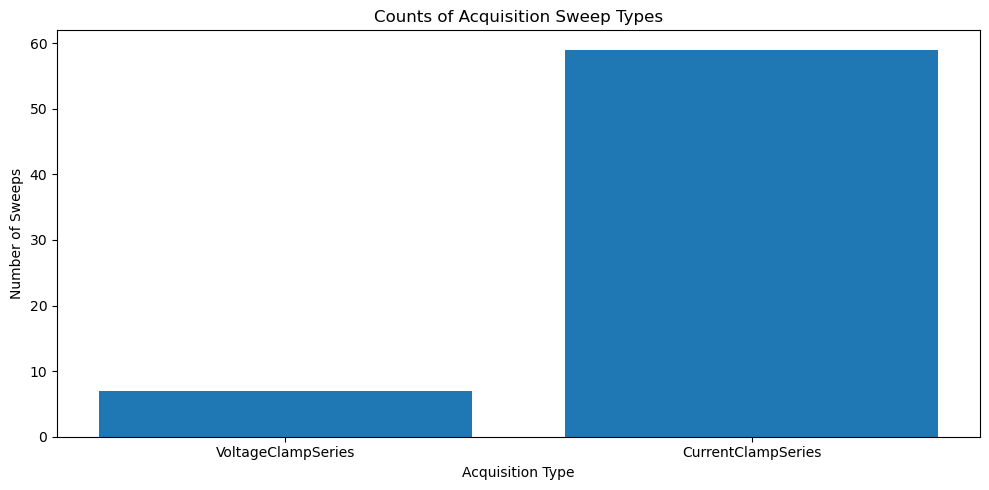

Total acquisition sweeps: 66
Sweep type counts: {'VoltageClampSeries': 7, 'CurrentClampSeries': 59}
Number of sweeps with detected spikes: 14
Total detected spikes (all sweeps): 431
Epochs (intervals) table: 3352 intervals available.


In [5]:
# Count types of acquisition sweeps
acq_types = [type(obj).__name__ for obj in nwb.acquisition.values()]
type_counts = Counter(acq_types)

# Count spike-containing sweeps (in 'spikes' processing module)
if 'spikes' in nwb.processing:
    spikes = nwb.processing['spikes']
    spike_sweep_counts = [(name, len(ifc.data[:])) for name, ifc in spikes.data_interfaces.items()]
    num_sweeps_with_spikes = sum(n > 0 for _, n in spike_sweep_counts)
    total_detected_spikes = sum(n for _, n in spike_sweep_counts)
else:
    spike_sweep_counts = []
    num_sweeps_with_spikes = 0
    total_detected_spikes = 0

# Plot the count of each acquisition type
plt.figure(figsize=(10, 5))
plt.bar(type_counts.keys(), type_counts.values())
plt.xlabel('Acquisition Type')
plt.ylabel('Number of Sweeps')
plt.title('Counts of Acquisition Sweep Types')
plt.tight_layout()
plt.show()

# Print numeric summaries
epochs_df = nwb.epochs.to_dataframe() if hasattr(nwb, 'epochs') and nwb.epochs is not None else None
print(f"Total acquisition sweeps: {len(nwb.acquisition)}")
print("Sweep type counts:", dict(type_counts))
print(f"Number of sweeps with detected spikes: {num_sweeps_with_spikes}")
print(f"Total detected spikes (all sweeps): {total_detected_spikes}")
if epochs_df is not None:
    print(f"Epochs (intervals) table: {len(epochs_df)} intervals available.")

The above summary shows that this NWB file contains both VoltageClampSeries and CurrentClampSeries data, with the majority being CurrentClamp recordings. About 14 of the 66 sweeps have at least one detected spike.

## Examining a Full Current Clamp Sweep

Let's select and plot a current clamp sweep alongside its corresponding stimulus to see what the raw data looks like.

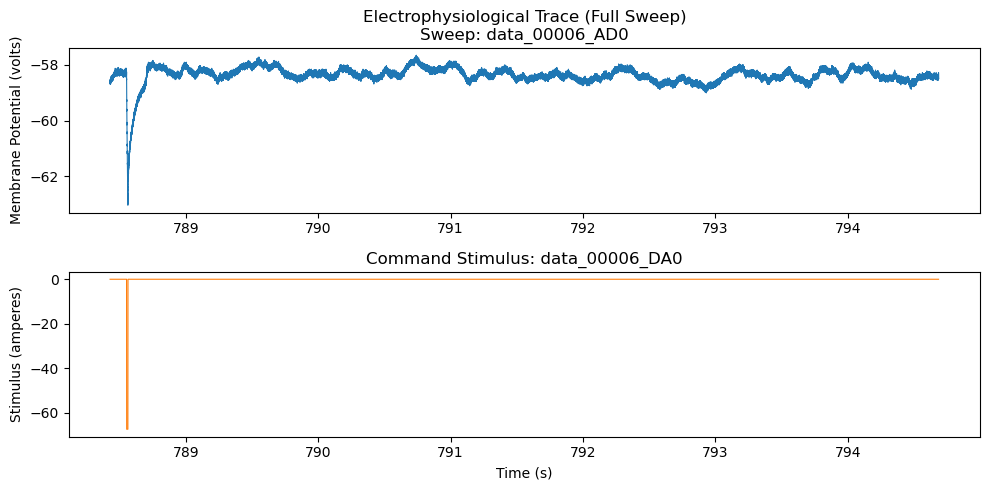

Sweep duration: 6.26 seconds
Sampling rate: 50000.00 Hz
Recording unit: volts
Stimulus unit: amperes


In [6]:
# Find a current clamp sweep in the file
cc_sweeps = [(name, obj) for name, obj in nwb.acquisition.items() 
             if type(obj).__name__ == 'CurrentClampSeries']
example_sweep_name, example_sweep = cc_sweeps[0]

# Get the corresponding stimulus series
stim_name = example_sweep_name.replace('_AD0', '_DA0')
example_stimulus = nwb.stimulus.get(stim_name)

# Load full trace and stimulus
trace = example_sweep.data[:]
stim = example_stimulus.data[:] if example_stimulus is not None else None
rate = example_sweep.rate
start_time = example_sweep.starting_time
t = np.arange(len(trace)) / rate + start_time

# Plot the full sweep
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(t, trace, color='tab:blue', linewidth=0.8)
plt.ylabel(f"Membrane Potential ({example_sweep.unit})")
plt.title(f"Electrophysiological Trace (Full Sweep)\nSweep: {example_sweep_name}")

plt.subplot(2, 1, 2)
if stim is not None:
    plt.plot(t, stim, color='tab:orange', linewidth=0.8)
    plt.ylabel(f"Stimulus ({example_stimulus.unit})")
    plt.title(f"Command Stimulus: {stim_name}")
else:
    plt.text(0.1, 0.5, 'No corresponding stimulus found', 
             ha='left', va='center', transform=plt.gca().transAxes)
plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()

print(f"Sweep duration: {t[-1] - t[0]:.2f} seconds")
print(f"Sampling rate: {rate:.2f} Hz")
print(f"Recording unit: {example_sweep.unit}")
print(f"Stimulus unit: {example_stimulus.unit if example_stimulus else 'N/A'}")

The plots above display a current clamp recording with its command stimulus. The trace shows the membrane potential (in volts) over time, and the stimulus trace shows the applied current (in amperes). Note the brief stimulus pulse and the corresponding response in the membrane potential.

## Detected Spikes Visualization

Next, let's find a sweep that has detected spikes and visualize them overlaid on the voltage trace.

*Note:* In this dataset, spike times require adjustment to align correctly with the trace. Specifically, we need to add both the sweep's starting time and an additional 0.25 second offset.

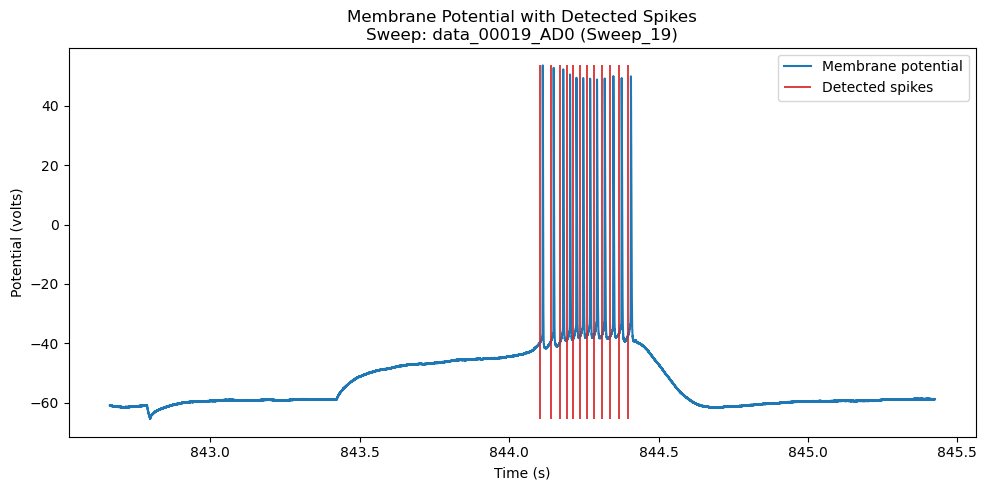

Sweep name: data_00019_AD0
Number of detected spikes: 12
First 10 spike times (in seconds): [844.10260003 844.13902003 844.17100003 844.19372003 844.21516003
 844.23768003 844.26090003 844.28398003 844.30972003 844.33866003]


In [7]:
# Find a sweep with detected spikes
spike_mod = nwb.processing['spikes']
sweep_with_spikes = None

for name, ts in spike_mod.data_interfaces.items():
    if hasattr(ts, 'data') and len(ts.data[:]) > 0:
        sweep_with_spikes = (name, ts)
        break

if sweep_with_spikes:
    sweep_name, spike_ts = sweep_with_spikes
    # Find the matching acquisition trace
    swnum = int(sweep_name.replace('Sweep_', ''))
    # Find acquisition that matches this sweep number
    match = [(nm, obj) for nm, obj in nwb.acquisition.items() 
             if hasattr(obj, 'sweep_number') and obj.sweep_number == swnum]
    
    if match:
        acq_name, acq_obj = match[0]
        trace = acq_obj.data[:]
        rate = acq_obj.rate
        start_time = acq_obj.starting_time
        t = np.arange(len(trace)) / rate + start_time
        
        # Load spike times and apply corrections for alignment
        spike_times = spike_ts.data[:] + start_time + 0.25
        
        # Handle NaN values for proper vlines display
        not_nan = ~np.isnan(trace)
        trace_min = np.min(trace[not_nan]) if np.any(not_nan) else -70
        trace_max = np.max(trace[not_nan]) if np.any(not_nan) else 40
        
        plt.figure(figsize=(10, 5))
        plt.plot(t, trace, label='Membrane potential', color='tab:blue')
        plt.vlines(spike_times, trace_min, trace_max, color='tab:red', 
                  label='Detected spikes', linewidth=1.25)
        plt.xlabel('Time (s)')
        plt.ylabel(f'Potential ({acq_obj.unit})')
        plt.title(f'Membrane Potential with Detected Spikes\nSweep: {acq_name} (Sweep_{swnum})')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        print(f"Sweep name: {acq_name}")
        print(f"Number of detected spikes: {len(spike_times)}")
        print(f"First 10 spike times (in seconds): {spike_times[:10]}")
    else:
        print("Could not match spike sweep to acquisition sweep.")
else:
    print("No sweep with detected spikes found in this file.")

This plot shows a current clamp sweep that generated action potentials (spikes). The vertical red lines mark where spikes were detected in the processing module. This particular sweep contains 12 spikes that occur in a burst pattern. The ability to access both the raw trace and precisely timed spike events enables detailed single-cell analyses.

## Exploring Experimental Protocol via Epochs

The NWB files in this dataset contain detailed annotations of experimental epochs or intervals. These intervals mark different phases of the experimental protocol with descriptive tags, allowing for protocol-aware analysis.

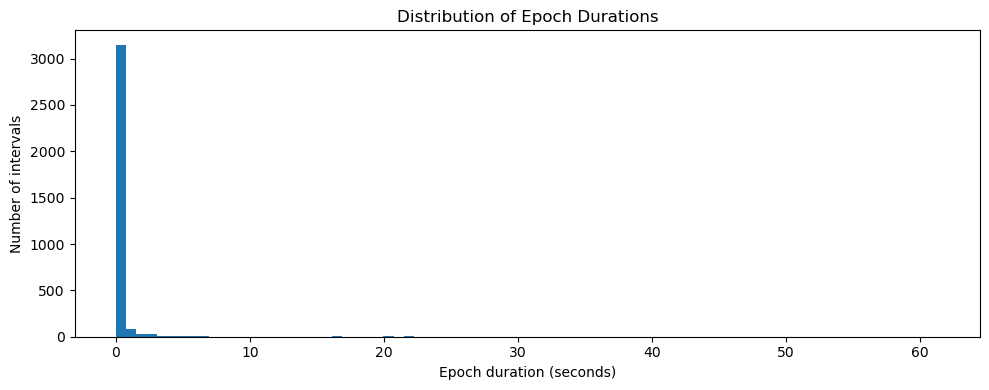

Epoch duration statistics:
count    3352.000000
mean        0.406164
std         2.393813
min         0.000453
25%         0.021827
50%         0.039837
75%         0.124521
max        61.384995
dtype: float64

Tag frequency (top 15 tags, flattened):
Type=Epoch                 2825
Epoch=1                    2666
EpochType=Sin Wave         2614
Amplitude=15               2075
Half Cycle=0                868
Half Cycle=1                865
Amplitude=14                515
EpochType=Square pulse      207
Type=Inserted Testpulse     196
Amplitude=0                 139
SubType=Baseline            128
Name=Baseline Chunk         115
Index=0                      78
ShortName=ST                 66
Type=Stimset                 66
Name: count, dtype: int64

Sample of epochs table (first 5 rows):
    start_time  stop_time                                               tags
id                                                                          
1       12.918     12.963  [Type=Inserted Testpul

In [8]:
# Access all epochs as dataframe
if hasattr(nwb, 'epochs') and nwb.epochs is not None:
    # Get all epochs
    epochs_df = nwb.epochs.to_dataframe().copy()
    
    # Calculate durations
    durations = epochs_df['stop_time'] - epochs_df['start_time']
    
    # Plot distribution of epoch durations
    plt.figure(figsize=(10, 4))
    plt.hist(durations, bins=80)
    plt.xlabel('Epoch duration (seconds)')
    plt.ylabel('Number of intervals')
    plt.title('Distribution of Epoch Durations')
    plt.tight_layout()
    plt.show()

    # Show descriptive statistics
    print('Epoch duration statistics:')
    print(durations.describe())
    
    # Show most common tags
    print('\nTag frequency (top 15 tags, flattened):')
    all_tags = [tag for tags_list in epochs_df['tags'] for tag in tags_list]
    tag_counts = pd.Series(all_tags).value_counts().head(15)
    print(tag_counts)
    
    # Show a small sample of the epochs table
    print('\nSample of epochs table (first 5 rows):')
    print(epochs_df[['start_time', 'stop_time', 'tags']].head(5))
else:
    print('No epochs table found in file.')

The epochs analysis reveals a highly structured experimental protocol with over 3,000 carefully annotated intervals. Most epochs are very brief (median duration of 0.04 seconds), likely representing individual stimulation pulses or test phases. 

The most common tags show that the protocol heavily features sin wave stimuli of different amplitudes and square pulses. These annotations allow researchers to selectively analyze specific protocol components or experimental phases and understand the relationships between stimulation parameters and neuronal responses.

## Summary and Next Steps

In this notebook, we've explored Dandiset 001359, which contains human Patch-seq electrophysiology data in the NWB format:

1. **Dataset Structure**: The dataset contains 391 NWB files from 33 human subjects, organized by subject IDs.

2. **File Content**: We examined a representative file containing both voltage and current clamp recordings, with corresponding stimuli, detected spike times, and detailed experimental annotations.

3. **Data Visualization**: We visualized raw electrophysiology traces, stimulus waveforms, and spikes overlay to demonstrate the core data in these files.

4. **Experimental Structure**: We explored the extensive epoch annotations that detail the experimental protocol phases and parameters.

### Potential investigations using this dataset:

- Extract and analyze electrophysiological features across different neurons
- Compare responses to specific stimulus types (sin waves vs. square pulses)
- Examine spiking patterns and threshold characteristics
- Correlate physiological properties with cell-type classification

The rich data structure and protocol annotation make this dataset particularly valuable for researchers interested in human neuronal diversity, cross-species comparisons, or multimodal cell-type classification analysis.